# Creating Usable Datasets for Models

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.feature_selection import chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression 
from sklearn.feature_selection import SelectKBest, SelectFromModel, VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
from sklearn import neighbors
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection as ms
sklearn.set_config(print_changed_only=False)

from matplotlib import pyplot as plt

import import_ipynb
from Self_Written_Functions_Sheet import col_obj_list, nan_col_list, cols_nan_unique, nan_col_obj_list_fillna, fill_masvnrtype
from Self_Written_Functions_Sheet import rmse, conversion

# from ML_HousingPrice_EDA_and_Basic_Imputation_Recover import hp_saleprice, hp_logsaleprice, hp

%store -r

importing Jupyter notebook from Self_Written_Functions_Sheet.ipynb


In [2]:
hp

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalBaths,BsmtBaths,BsmtFinTotalSF,BsmtUnfin,2ndFlr,LowQualFin,TotalPorchSF,Porches,Decks,YrsRemodToSold
0,1,60,RL,65.0,8450,Pave,DNE,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,DNE,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,DNE,DNE,DNE,0,2,2008,WD,Normal,2.5,1.0,706,1,1,0,61,1,0,5
1,2,20,RL,80.0,9600,Pave,DNE,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,DNE,DNE,DNE,0,5,2007,WD,Normal,2.0,0.5,978,1,0,0,0,0,1,31
2,3,60,RL,68.0,11250,Pave,DNE,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,DNE,DNE,DNE,0,9,2008,WD,Normal,2.5,1.0,486,1,1,0,42,1,0,6
3,4,70,RL,60.0,9550,Pave,DNE,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,DNE,DNE,DNE,0,2,2006,WD,Abnorml,1.0,1.0,216,1,1,0,307,1,0,36
4,5,60,RL,84.0,14260,Pave,DNE,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,DNE,DNE,DNE,0,12,2008,WD,Normal,2.5,1.0,655,1,1,0,84,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,1456,60,RL,62.0,7917,Pave,DNE,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,DNE,DNE,DNE,0,8,2007,WD,Normal,2.5,0.0,0,1,1,0,40,1,0,7
1454,1457,20,RL,85.0,13175,Pave,DNE,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,DNE,MnPrv,DNE,0,2,2010,WD,Normal,2.0,1.0,953,1,0,0,0,0,1,22
1455,1458,70,RL,66.0,9042,Pave,DNE,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attch

In [3]:
hp.loc[:, hp.isnull().any()]

,LotFrontage
0,65.0
1,80.0
2,68.0
3,60.0
4,84.0
...,...
1453,62.0
1454,85.0
1455,66.0
1456,68.0


# Lot Frontage Imputation

In [4]:
# dummify the variables
hp_dum = pd.get_dummies(hp, drop_first=True)

# one hot encoding for mssubclass since it is numeric
enc = OneHotEncoder(drop='first')
enc.fit(hp_dum[['MSSubClass']])

oh_labels = enc.transform(hp_dum[['MSSubClass']]).toarray()
mssubcl_dum = pd.DataFrame(oh_labels)

mssubcl_dum.columns = enc.get_feature_names(['MSSubClass'])

# Concatenate the dataframes and drop Id and original MSSubClass
hp_dum = pd.concat([hp_dum, mssubcl_dum], axis=1, sort=False)
hp_dum = hp_dum.drop(['Id', 'MSSubClass'], axis=1)
hp_dum

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,BsmtBaths,BsmtFinTotalSF,BsmtUnfin,2ndFlr,LowQualFin,TotalPorchSF,Porches,Decks,YrsRemodToSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_

In [5]:
hp_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Columns: 281 entries, LotFrontage to MSSubClass_190
dtypes: float64(19), int64(40), uint8(222)
memory usage: 988.3 KB


In [6]:
hp_dum.isnull().sum().sum()

259

### Separate LotFrontage from the rest of the features

In [7]:
hp_lf = hp[['LotFrontage']]
hp_dum_nolf = hp_dum.drop(['LotFrontage'], axis=1)

lf_isnull = list(hp_lf.loc[hp_lf.LotFrontage.isna()].index)

lf_notnull = list(hp_lf.loc[hp_lf.LotFrontage.notna()].index)

hp_dum_nolf_train = hp_dum_nolf.iloc[lf_notnull]
hp_dum_lf_train = hp_lf.iloc[lf_notnull]

hp_dum_nolf_null = hp_dum_nolf.iloc[lf_isnull]
hp_dum_lf_null = hp_lf.iloc[lf_isnull]

In [8]:
hp_dum_lf_train

,LotFrontage
0,65.0
1,80.0
2,68.0
3,60.0
4,84.0
...,...
1453,62.0
1454,85.0
1455,66.0
1456,68.0


In [9]:
hp_dum_lf_null

,LotFrontage
7,NaN
12,NaN
14,NaN
16,NaN
24,NaN
...,...
1427,NaN
1429,NaN
1439,NaN
1441,NaN


### Get list of columns that have dtype != object

In [10]:
cols_obj_dum = []
cols_num_dum = []

# the function below creates a list of column names with dtype=='object'
# and a list of column names with dtype!='object'
col_obj_list(hp, hp.columns, cols_obj_dum, cols_num_dum)

# we are removing Id and MSSubclass
    # Id because it has no bearing on the result
    # MSSubClass because it is categorical

to_remove = ['Id', 'MSSubClass', 'LotFrontage', 'Decks',
             'Porches', 'LowQualFin', '2ndFlr', 'BsmtUnfin']

cols_num_dum = [x for x in cols_num_dum if x not in to_remove]
cols_num_dum

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'TotalBaths',
 'BsmtBaths',
 'BsmtFinTotalSF',
 'TotalPorchSF',
 'YrsRemodToSold']

### Create DF of dtype != Object for standardization

In [11]:
hp_num_dum = hp[cols_num_dum]
hp_num_dum

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,BsmtBaths,BsmtFinTotalSF,TotalPorchSF,YrsRemodToSold
0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,2.5,1.0,706,61,5
1,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,2.0,0.5,978,0,31
2,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,2.5,1.0,486,42,6
3,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,1.0,1.0,216,307,36
4,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,2.5,1.0,655,84,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,2.5,0.0,0,40,7
1454,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,2.0,1.0,953,0,22
1455,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,2.0,0.0,275,60,4
1456,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,1.0,1.0,1078,112,14


# Standardization Process

In [12]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
strdscaler = StandardScaler()
standardized = strdscaler.fit_transform(hp_num_dum)
hp_num_strd = pd.DataFrame(standardized, columns = hp_num_dum.columns)

hp_num_strd

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,BsmtBaths,BsmtFinTotalSF,TotalPorchSF,YrsRemodToSold
0,-0.203934,0.658506,-0.517649,1.052959,0.880362,0.523014,0.617283,-0.288867,-0.943795,-0.473766,-0.814309,1.167626,-0.120325,0.393013,1.113886,-0.241236,0.793546,1.229699,0.163894,-0.211605,0.921812,-0.952231,0.296262,0.313159,0.357973,-0.750831,0.225982,-0.359603,-0.11642,-0.270407,-0.063709,-0.087748,-1.601578,0.138375,1.174852,1.066169,0.485432,-0.245576,-0.871676
1,-0.087252,-0.068293,2.177825,0.158428,-0.428115,-0.571872,1.245719,-0.288867,-0.640584,0.504925,0.277348,-0.794354,-0.120325,-0.489391,-0.819502,3.945931,0.793546,-0.760202,0.163894,-0.211605,-0.316329,0.605965,0.236767,0.313159,-0.056795,1.627328,-0.708304,-0.359603,-0.11642,-0.270407,-0.063709,-0.087748,-0.490155,-0.614427,0.386571,0.092188,1.084079,-0.827879,0.388660
2,0.080162,0.658506,-0.517649,0.986698,0.831900,0.333085,0.108989,-0.288867,-0.301168,-0.319490,-0.642225,1.195195,-0.120325,0.542706,1.113886,-0.241236,0.793546,1.229699,0.163894,-0.211605,-0.316329,0.605965,0.291855,0.313159,0.640770,-0.750831,-0.065025,-0.359603,-0.11642,-0.270407,-0.063709,-0.087748,0.991743,0.138375,1.174852,1.066169,0.001232,-0.426949,-0.823201
3,-0.092325,0.658506,-0.517649,-1.862551,-0.718888,-0.571872,-0.514826,-0.288867,-0.061314,-0.714823,-0.531984,0.942481,-0.120325,0.406800,1.113886,-0.241236,-1.025620,-0.760202,0.163894,-0.211605,0.302742,0.605965,0.285244,1.652119,0.801022,-0.750831,-0.172238,4.089589,-0.11642,-0.270407,-0.063709,-0.087748,-1.601578,-1.367230,-1.189990,1.066169,-0.593014,2.102728,0.631032
4,0.385566,1.385305,-0.517649,0.953567,0.734975,1.383282,0.499451,-0.288867,-0.174452,0.222888,-0.037243,1.624809,-0.120325,1.354202,1.113886,-0.241236,0.793546,1.229699,1.389320,-0.211605,1.540882,0.605965,0.289651,1.652119,1.715398,0.781406,0.578253,-0.359603,-0.11642,-0.270407,-0.063709,-0.087748,2.103167,0.138375,1.174852,1.066169,0.373185,-0.026019,-0.726252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,-0.258014,-0.068293,-0.517649,0.920436,0.734975,-0.571872,-1.013878,-0.288867,0.873212,-0.239941,-0.553494,0.800042,-0.120325,0.268925,-0.819502,-0.241236,0.793546,1.229699,0.163894,-0.211605,0.302742,0.605965,0.287448,0.313159,-0.056795,-0.750831,-0.095658,-0.359603,-0.11642,-0.270407,-0.063709,-0.087748,0.621269,-0.614427,1.174852,-0.881794,-1.068410,-0.446041,-0.774727
1454,0.275478,-0.068293,0.380842,0.224690,0.153430,0.092880,0.811359,0.721263,0.049562,1.179884,2.457972,-0.794354,-0.120325,1.107996,1.113886,-0.241236,0.793546,-0.760202,0.163894,-0.211605,0.302742,2.164162,0.241174,0.313159,0.131736,2.034328,-0.708304,-0.359603,-0.11642,-0.270407,-0.063709,-0.087748,-1.601578,1.643980,0.386571,1.066169,1.029056,-0.827879,-0.047610
1455,-0.143868,0.658506,3.076316,-1.001150,1.025748,-0.571872,-0.378511,-0.288867,0.701241,0.239762,0.078376,1.852252,-0.120325,1.633893,-0.819502,-0.241236,0.793546,-0.760202,1.389320,-0.211605,1.540882,2.164162,0.159645,-1.025802,-1.037158,-0.750831,0.210665,-0.359603,-0.11642,-0.270407,-0.063709,4.949624,-0.490155,1.643980,0.386571,-0.881794,-0.463160,-0.255122,-0.920150
1456,-0.075381,-0.795092,0.380842,-0.702973,0.541127,-0.571872,-0.900667,6.087966,-1.283211,0.061380,-0.217393,-0.794354,-0.120325,-0.851806,1.113886,-0.241236,-1.025620,-0.760202,-1.061532,-0.211605,-0.935399,-0.952231,0.179476,-1.025802,-1.093717,2.169995,-0.708304,1.472417,-0.11642,-0.270407,-0.063709,-0.087748,-0.860629,1.643980,-1.189990,1.066169,1.304170,0.241268,-0.435406


In [13]:
hp_dum

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,BsmtBaths,BsmtFinTotalSF,BsmtUnfin,2ndFlr,LowQualFin,TotalPorchSF,Porches,Decks,YrsRemodToSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_

In [14]:
# drop columns in hp_dum to prevent duplicate features during concatenation

hp_dum = hp_dum.drop(cols_num_dum, axis=1)
hp_dum

,LotFrontage,BsmtUnfin,2ndFlr,LowQualFin,Porches,Decks,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,65.0,1,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

In [15]:
# Concatenate the dummified df and the standardized df
hp_full_strd_nolf = pd.concat([hp_num_strd, hp_dum], axis=1, sort=False)
%store hp_full_strd_nolf

# drop LotFrontage for imputation
hp_strd_nolf = hp_full_strd_nolf.drop(['LotFrontage'], axis=1)
hp_strd_nolf

Stored 'hp_full_strd_nolf' (DataFrame)


,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,BsmtBaths,BsmtFinTotalSF,TotalPorchSF,YrsRemodToSold,BsmtUnfin,2ndFlr,LowQualFin,Porches,Decks,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType

In [16]:
# split the train and test sets for 

hp_nolf_train = hp_strd_nolf.iloc[lf_notnull]
hp_lf_train = hp_lf.iloc[lf_notnull]

hp_nolf_null = hp_strd_nolf.iloc[lf_isnull]
hp_lf_null = hp_lf.iloc[lf_isnull]

In [17]:
hp_nolf_train

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,BsmtBaths,BsmtFinTotalSF,TotalPorchSF,YrsRemodToSold,BsmtUnfin,2ndFlr,LowQualFin,Porches,Decks,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType

## Imputation of LotFrontage

### Attempt with Ridge

In [18]:
ridge = Ridge(random_state=0, max_iter=100000)

alphas = np.logspace(-2, 3, 100)

gparam_ridge = [{'alpha': alphas}]
n_folds_lin = ms.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

gs_ridge = GridSearchCV(ridge, gparam_ridge, cv=n_folds_lin)
%time gs_ridge.fit(hp_nolf_train, hp_lf_train)

print(gs_ridge.best_params_)
print(gs_ridge.best_score_)

C:\Users\tdcho\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Wall time: 7.82 s
{'alpha': 27.1858824273294}
0.44849885978114046


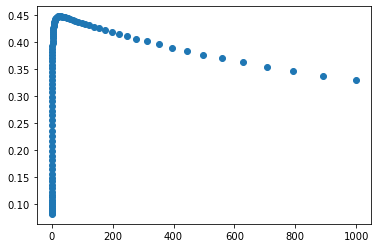

In [19]:
plt.scatter(gs_ridge.cv_results_['param_alpha'], gs_ridge.cv_results_['mean_test_score'])

C:\Users\tdcho\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Wall time: 3.69 s
{'alpha': 25.918367346938776}
0.4485232632839728


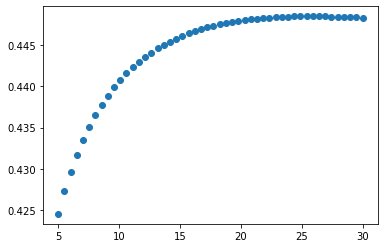

In [20]:
alphas = np.linspace(5, 30, 50)
gparam_ridge = [{'alpha': alphas}]

gs_ridge = GridSearchCV(ridge, gparam_ridge, cv=n_folds_lin)
%time gs_ridge.fit(hp_nolf_train, hp_lf_train)

print(gs_ridge.best_params_)
print(gs_ridge.best_score_)
plt.scatter(gs_ridge.cv_results_['param_alpha'], gs_ridge.cv_results_['mean_test_score'])

### Attempt with Lasso

C:\Users\tdcho\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Wall time: 3.73 s
{'alpha': 0.18307382802953678}
0.4741024051167626


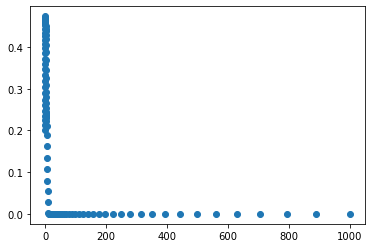

In [21]:
lasso = Lasso(random_state=0, max_iter=1000000)

alphas = np.logspace(-2, 3, 100)

gparam_lasso = [{'alpha': alphas}]

gs_lasso = GridSearchCV(lasso, gparam_lasso, cv=n_folds_lin, n_jobs=-1)
%time gs_lasso.fit(hp_nolf_train, hp_lf_train)

print(gs_lasso.best_params_)
print(gs_lasso.best_score_)

plt.scatter(gs_lasso.cv_results_['param_alpha'], gs_lasso.cv_results_['mean_test_score'])

C:\Users\tdcho\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Wall time: 934 ms
{'alpha': 0.18333333333333335}
0.4740544657292613


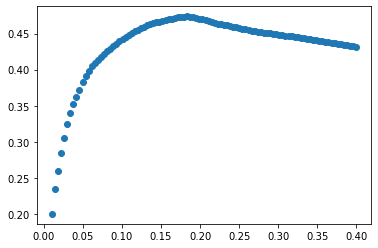

In [22]:
lasso = Lasso(random_state=0, max_iter=100000)

alphas = np.linspace(1e-2, 0.4, 100)

gparam_lasso = [{'alpha': alphas}]

gs_lasso = GridSearchCV(lasso, gparam_lasso, cv=n_folds_lin, n_jobs=-1)
%time gs_lasso.fit(hp_nolf_train, hp_lf_train)

print(gs_lasso.best_params_)
print(gs_lasso.best_score_)

plt.scatter(gs_lasso.cv_results_['param_alpha'], gs_lasso.cv_results_['mean_test_score'])

### Attempt with Gradient Boosting

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(random_state=0, loss='ls',
                                min_impurity_decrease=0.1, 
                                warm_start=False)

learningrate = [0.0001, 0.001, 0.01, 0.1, 1]
nestimators = [5, 10, 50, 100, 200, 500, 1000,
               1500, 2000, 5000]
# subsamples = np.linspace(0, 1, 100)
maxfeatures = [9, 40, len(hp_nolf_train.columns)]
maxdepth = range(1, 5)

ytrain_array_a = hp_lf_train.values.flatten()

gparam_gbm = [{'learning_rate': learningrate},
              {'n_estimators': nestimators},
              {'max_features': maxfeatures},
              {'max_depth': maxdepth}]

n_folds=ms.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

gs_gbm = GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1)
%time gs_gbm.fit(hp_nolf_train, ytrain_array_a)

C:\Users\tdcho\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Wall time: 19.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.1,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,...
                                                 random_state=0, subsample=1.0,
                                                 tol=0.0001,
                      

In [24]:
print(gs_gbm.best_params_)
print(gs_gbm.best_score_)

gbm_imp_feat = sorted(zip(hp_nolf_train.columns, 
                          gs_gbm.best_estimator_.feature_importances_),
                      key=lambda t:t[1], reverse=True)

# print out most important features
gbm_imp_feat

{'max_depth': 4}
0.5185826625962017


[('LotArea', 0.5103933120982482),
 ('LotConfig_CulDSac', 0.04472451746009886),
 ('Condition1_PosA', 0.02851668097688463),
 ('YearBuilt', 0.028317947413105882),
 ('GrLivArea', 0.02360738910277129),
 ('LotConfig_Inside', 0.019317323063158094),
 ('LotShape_IR3', 0.01850297989979047),
 ('1stFlrSF', 0.017058677862275155),
 ('Heating_Grav', 0.016660535238348467),
 ('GarageArea', 0.016531846433075245),
 ('TotalBsmtSF', 0.01553247047413973),
 ('GarageType_Detchd', 0.011089851460624366),
 ('PoolQC_Ex', 0.011051990249122977),
 ('TotRmsAbvGrd', 0.010779247526614383),
 ('LotShape_IR2', 0.010197167994842713),
 ('RoofMatl_Tar&Grv', 0.009186867197999249),
 ('EnclosedPorch', 0.009035606232881147),
 ('LandContour_Lvl', 0.007916645838488999),
 ('OpenPorchSF', 0.00790899664911502),
 ('BedroomAbvGr', 0.0076905126376208815),
 ('WoodDeckSF', 0.007585557103556771),
 ('GarageYrBlt', 0.007410234458413304),
 ('YearRemodAdd', 0.0070039978154892496),
 ('BsmtQual_Gd', 0.006571675774261027),
 ('2ndFlrSF', 0.0064829

In [25]:
# trim features so df will only have important features
gbm_top_important_features = [x[0] for x in gbm_imp_feat if x[1] > 0.0]

lf_tree_gbm = hp_full_strd_nolf[[*gbm_top_important_features]]
lf_tree_gbm

,LotArea,LotConfig_CulDSac,Condition1_PosA,YearBuilt,GrLivArea,LotConfig_Inside,LotShape_IR3,1stFlrSF,Heating_Grav,GarageArea,TotalBsmtSF,GarageType_Detchd,PoolQC_Ex,TotRmsAbvGrd,LotShape_IR2,RoofMatl_Tar&Grv,EnclosedPorch,LandContour_Lvl,OpenPorchSF,BedroomAbvGr,WoodDeckSF,GarageYrBlt,YearRemodAdd,BsmtQual_Gd,2ndFlrSF,Foundation_Wood,LotConfig_FR2,GarageFinish_Unf,MSSubClass_120,Foundation_CBlock,BsmtFinTotalSF,MasVnrArea,BsmtUnfSF,BldgType_TwnhsE,LandContour_HLS,OverallQual,LotShape_Reg,TotalPorchSF,BsmtFinSF1,FireplaceQu_TA,FireplaceQu_Gd,LandSlope_Mod,YrsRemodToSold,ExterQual_TA,Neighborhood_Timber,KitchenQual_TA,BsmtCond_Fa,BsmtFinType2_BLQ,MoSold,GarageType_Basment,3SsnPorch,YrSold,KitchenQual_Fa,Fireplaces,Condition1_RRNn,PoolArea,Condition1_Feedr,MSZoning_RM,Neighborhood_Mitchel,MSSubClass_60,Neighborhood_NoRidge,GarageFinish_RFn,Neighborhood_Crawfor,Alley_Grvl,Neighborhood_CollgCr,BsmtFinType2_Rec,Neighborhood_Gilbert,Neighborhood_NridgHt,GarageType_Attchd,Exterior2nd_Plywood,Condition2_Norm,MSSubClass_80,Condition1_RRAn,BsmtFinType1_GLQ,OverallCond,BsmtFinType1_BLQ,Street_Pave,Fence_MnPrv,Functional_Min2,Exterior1st_WdShing,HouseStyle_2Story,ScreenPorch,Neighborhood_StoneBr,BsmtExposure_Mn,MSSubClass_40,BldgType_Twnhs,Neighborhood_BrkSide,LowQualFinSF,MSSubClass_160,Neighborhood_Sawyer,BsmtQual_TA,TotalBaths,Neighborhood_Veenker,Fence_GdWo,LandContour_Low,MSSubClass_50,BsmtQual_Ex,ExterQual_Gd,Neighborhood_NWAmes,Condition1_RRAe,GarageQual_Fa,Exterior2nd_VinylSd,GarageCars,Fence_MnWw,KitchenAbvGr,CentralAir_Y,Decks,RoofStyle_Hip,Exterior2nd_CBlock,Exterior1st_HdBoard,Exterior1st_CBlock,Neighborhood_OldTown,Neighborhood_Edwards,MasVnrType_Stone,KitchenQual_Gd,Electrical_FuseF,Exterior2nd_MetalSd,BsmtFinSF2,Condition2_Feedr,RoofStyle_Gable,SaleType_Oth,GarageQual_Gd,PavedDrive_P,FullBath,BsmtExposure_Gd,BsmtFinType2_Unf,Exterior2nd_Wd Shng,LotConfig_FR3,Exterior1st_VinylSd,ExterCond_Gd,GarageFinish_Fin,HeatingQC_TA,Exterior1st_Plywood,MSSubClass_70,BsmtHalfBath,MSSubClass_190,ExterQual_Fa,Electrical_SBrkr,Alley_Pave,Functional_Typ,Electrical_FuseP,MSZoning_FV,SaleType_WD,MSSubClass_85,BsmtExposure_No,BsmtFullBath,BsmtBaths,HeatingQC_Gd,Foundation_Stone,GarageCond_TA,MasVnrType_BrkFace,BsmtFinType2_LwQ,BsmtCond_TA,Condition1_Norm,Porches,Exterior2nd_HdBoard,RoofStyle_Gambrel,GarageType_BuiltIn,Exterior1st_Wd Sdng,BsmtFinType1_Unf,ExterCond_TA,HalfBath,HouseStyle_1Story
0,-0.203934,0,0,1.052959,0.393013,1,0,-0.814309,0,0.357973,-0.473766,0,0,0.921812,0,0,-0.359603,1,0.225982,0.163894,-0.750831,0.296262,0.880362,1,1.167626,0,0,0,0.0,0,0.485432,0.523014,-0.943795,0,0,0.658506,1,-0.245576,0.617283,0,0,0,-0.871676,0,0,0,0,0,-1.601578,0,-0.11642,0.138375,0,-0.952231,0,-0.063709,0,0,0,1.0,0,1,0,0,1,0,0,0,1,0,1,0.0,0,1,-0.517649,0,1,0,0,0,1,-0.270407,0,0,0.0,0,0,-0.120325,0.0,0,0,1.174852,0,0,0,0.0,0,1,0,0,0,1,0.313159,0,-0.211605,1,0,0,0,0,0,0,0,0,1,0,0,-0.288867,0,1,0,0,0,0.793546,0,1,0,0,1,0,0,0,0,0.0,-0.241236,0.0,0,1,0,1,0,0,1,0.0,1,1.113886,1.066169,0,0,1,1,0,1,1,1,0,0,0,0,0,1,1.229699,0
1,-0.087252,0,0,0.158428,-0.489391,0,0,0.277348,0,-0.056795,0.504925,0,0,-0.316329,0,0,-0.359603,1,-0.708304,0.163894,1.627328,0.236767,-0.428115,1,-0.794354,0,1,0,0.0,1,1.084079,-0.571872,-0.640584,0,0,-0.068293,1,-0.827879,1.245719,1,0,0,0.388660,1,0,1,0,0,-0.490155,0,-0.11642,-0.614427,0,0.605965,0,-0.063709,1,0,0,0.0,0,1,0,0,0,0,0,0,1,0,1,0.0,0,0,2.177825,0,1,0,0,0,0,-0.270407,0,0,0.0,0,0,-0.120325,0.0,0,0,0.386571,1,0,0,0.0,0,0,0,0,0,0,0.313159,0,-0.211605,1,1,0,0,0,0,0,0,0,0,0,1,-0.288867,0,1,0,0,0,0.793546,1,1,0,0,0,0,0,0,0,0.0,3.945931,0.0,0,1,0,1,0,0,1,0.0,0,-0.819502,0.092188,0,0,1,0,0,1,0,0,0,0,0,0,0,1,-0.760202,1
2,0.080162,0,0,0.986698,0.542706,1,0,-0.642225,0,0.640770,-0.319490,0,0,-0.316329,0,0,-0.359603,1,-0.065025,0.163894,-0.750831,0.291855,0.831900,1,1.195195,0,0,0,0.0,0,0.001232,0.333085,-0.301168,0,0,0.658506,0,-0.426949,0.108989,1,0,0,-0.823201,0,0,0,0,0,0.991743,0,-0.11642,0.138375,0,0.605965,0,-0.063709,0,0,0,1.0,0

In [26]:
# revise training and test datasets
lf_tree_gbm_train = lf_tree_gbm.iloc[lf_notnull]

lf_tree_gbm_null = lf_tree_gbm.iloc[lf_isnull]

In [27]:
gbm = GradientBoostingRegressor(random_state=0, loss='ls',
                                min_impurity_decrease=0.1, 
                                warm_start=False)

learningrate = [0.0001, 0.001, 0.01, 0.1, 1] # subsequently, fine tune
nestimators = [5, 10, 50, 100, 200, 500, 1000,
               1500, 2000, 5000]
# subsamples = np.linspace(0, 1, 100)
maxfeatures = [9, 40, len(lf_tree_gbm_train.columns)]
maxdepth = range(1, 5)

ytrain_array = hp_lf_train.values.flatten()


gparam_gbm = [{'learning_rate': learningrate},
              {'n_estimators': nestimators},
#               {'subsample': subsamples}, 
              {'max_features': maxfeatures},
              {'max_depth': maxdepth}]

n_folds=ms.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

gs_gbm = GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1)
%time gs_gbm.fit(lf_tree_gbm_train, hp_lf_train)

C:\Users\tdcho\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Wall time: 14.5 s


C:\Users\tdcho\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.1,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,...
                                                 random_state=0, subsample=1.0,
                                                 tol=0.0001,
                      

In [28]:
print(gs_gbm.best_params_)
print(gs_gbm.best_score_)

# gbm_imp_feat = sorted(zip(hp_tree_nolf_train.columns, 
#                           gs_gbm.best_estimator_.feature_importances_), key=lambda t:t[1], reverse=True)
# gbm_imp_feat

{'max_features': 40}
0.5350756240845266


In [29]:
grid_report = pd.DataFrame(gs_gbm.cv_results_)
grid_report.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
mean_fit_time,0.609289,0.613492,0.615794,0.604585,0.611391,0.03803,0.067654,0.31075,0.619497,1.227085,3.057354,5.694269,8.046758,8.854806,13.404858,0.075861,0.17444,0.616294,0.227282,0.433248,0.620398,0.793337
std_fit_time,0.007871,0.011607,0.01164,0.00252,0.007825,0.000548,0.00049,0.007937,0.010068,0.010267,0.022509,0.040538,0.050721,0.049348,0.091258,0.014954,0.005089,0.010642,0.004424,0.028958,0.016133,0.016725
mean_score_time,0.004403,0.004804,0.004903,0.004804,0.004804,0.004404,0.004203,0.004103,0.004504,0.004804,0.005504,0.006105,0.007106,0.006806,0.007706,0.004404,0.004404,0.004504,0.004304,0.004504,0.004504,0.004203
std_score_time,0.0002,0.000245,0.000374,0.0004,0.000245,0.0002,0.000245,0.0002,0.000317,0.000245,0.000317,0.000736,0.000374,0.000245,0.000245,0.0002,0.0002,0.0,0.000245,0.0,0.0,0.0006
param_learning_rate,0.0001,0.001,0.01,0.1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
param_n_estimators,NaN,NaN,NaN,NaN,NaN,5,10,50,100,200,500,1000,1500,2000,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
param_max_features,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,40,163,NaN,NaN,NaN,NaN
param_max_depth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,3,4
params,{'learning_rate': 0.0001},{'learning_rate': 0.001},{'learning_rate': 0.01},{'learning_rate': 0.1},{'learning_rate': 1},{'n_estimators': 5},{'n_estimators': 10},{'n_estimators': 50},{'n_estimators': 100},{'n_estimators': 200},{'n_estimators': 500},{'n_estimators': 1000},{'n_estimators': 1500},{'n_estimators': 2000},{'n_estimators': 5000},{'max_features': 9},{'max_features': 40},{'max_features': 163},{'max_depth': 1},{'max_depth': 2},{'max_depth': 3},{'max_depth': 4}
split0_test_score,0.00972,0.087931,0.405832,0.521684,0.380881,0.303477,0.413888,0.507063,0.521684,0.490987,0.451948,0.42903,0.421643,0.421575,0.421575,0.521076,0.551673,0.521684,0.491398,0.552957,0.521684,0.525846


In [30]:
grid_report.sort_values('mean_test_score', ascending=False).head().T

,16,21,15,7,20
mean_fit_time,0.17444,0.793337,0.075861,0.31075,0.620398
std_fit_time,0.005089,0.016725,0.014954,0.007937,0.016133
mean_score_time,0.004404,0.004203,0.004404,0.004103,0.004504
std_score_time,0.0002,0.0006,0.0002,0.0002,0.0
param_learning_rate,NaN,NaN,NaN,NaN,NaN
param_n_estimators,NaN,NaN,NaN,50,NaN
param_max_features,40,NaN,9,NaN,NaN
param_max_depth,NaN,4,NaN,NaN,3
params,{'max_features': 40},{'max_depth': 4},{'max_features': 9},{'n_estimators': 50},{'max_depth': 3}
split0_test_score,0.551673,0.525846,0.521076,0.507063,0.521684


## Retry with even smaller set

In [31]:
# trim features so df will only have important features
gbm_top_important_features = [x[0] for x in gbm_imp_feat if x[1] > 0.001]

lf_tree_gbm = hp_full_strd_nolf[[*gbm_top_important_features]]
lf_tree_gbm

,LotArea,LotConfig_CulDSac,Condition1_PosA,YearBuilt,GrLivArea,LotConfig_Inside,LotShape_IR3,1stFlrSF,Heating_Grav,GarageArea,TotalBsmtSF,GarageType_Detchd,PoolQC_Ex,TotRmsAbvGrd,LotShape_IR2,RoofMatl_Tar&Grv,EnclosedPorch,LandContour_Lvl,OpenPorchSF,BedroomAbvGr,WoodDeckSF,GarageYrBlt,YearRemodAdd,BsmtQual_Gd,2ndFlrSF,Foundation_Wood,LotConfig_FR2,GarageFinish_Unf,MSSubClass_120,Foundation_CBlock,BsmtFinTotalSF,MasVnrArea,BsmtUnfSF,BldgType_TwnhsE,LandContour_HLS,OverallQual,LotShape_Reg,TotalPorchSF,BsmtFinSF1,FireplaceQu_TA,FireplaceQu_Gd,LandSlope_Mod,YrsRemodToSold,ExterQual_TA,Neighborhood_Timber,KitchenQual_TA,BsmtCond_Fa,BsmtFinType2_BLQ,MoSold,GarageType_Basment,3SsnPorch,YrSold,KitchenQual_Fa,Fireplaces,Condition1_RRNn,PoolArea,Condition1_Feedr,MSZoning_RM,Neighborhood_Mitchel,MSSubClass_60,Neighborhood_NoRidge,GarageFinish_RFn,Neighborhood_Crawfor,Alley_Grvl,Neighborhood_CollgCr,BsmtFinType2_Rec,Neighborhood_Gilbert
0,-0.203934,0,0,1.052959,0.393013,1,0,-0.814309,0,0.357973,-0.473766,0,0,0.921812,0,0,-0.359603,1,0.225982,0.163894,-0.750831,0.296262,0.880362,1,1.167626,0,0,0,0.0,0,0.485432,0.523014,-0.943795,0,0,0.658506,1,-0.245576,0.617283,0,0,0,-0.871676,0,0,0,0,0,-1.601578,0,-0.11642,0.138375,0,-0.952231,0,-0.063709,0,0,0,1.0,0,1,0,0,1,0,0
1,-0.087252,0,0,0.158428,-0.489391,0,0,0.277348,0,-0.056795,0.504925,0,0,-0.316329,0,0,-0.359603,1,-0.708304,0.163894,1.627328,0.236767,-0.428115,1,-0.794354,0,1,0,0.0,1,1.084079,-0.571872,-0.640584,0,0,-0.068293,1,-0.827879,1.245719,1,0,0,0.388660,1,0,1,0,0,-0.490155,0,-0.11642,-0.614427,0,0.605965,0,-0.063709,1,0,0,0.0,0,1,0,0,0,0,0
2,0.080162,0,0,0.986698,0.542706,1,0,-0.642225,0,0.640770,-0.319490,0,0,-0.316329,0,0,-0.359603,1,-0.065025,0.163894,-0.750831,0.291855,0.831900,1,1.195195,0,0,0,0.0,0,0.001232,0.333085,-0.301168,0,0,0.658506,0,-0.426949,0.108989,1,0,0,-0.823201,0,0,0,0,0,0.991743,0,-0.11642,0.138375,0,0.605965,0,-0.063709,0,0,0,1.0,0,1,0,0,1,0,0
3,-0.092325,0,0,-1.862551,0.406800,0,0,-0.531984,0,0.801022,-0.714823,1,0,0.302742,0,0,4.089589,1,-0.172238,0.163894,-0.750831,0.285244,-0.718888,0,0.942481,0,0,1,0.0,0,-0.593014,-0.571872,-0.061314,0,0,0.658506,0,2.102728,-0.514826,0,1,0,0.631032,1,0,0,0,0,-1.601578,0,-0.11642,-1.367230,0,0.605965,0,-0.063709,0,0,0,0.0,0,0,1,0,0,0,0
4,0.385566,0,0,0.953567,1.354202,0,0,-0.037243,0,1.715398,0.222888,0,0,1.540882,0,0,-0.359603,1,0.578253,1.389320,0.781406,0.289651,0.734975,1,1.624809,0,1,0,0.0,0,0.373185,1.383282,-0.174452,0,0,1.385305,0,-0.026019,0.499451,1,0,0,-0.726252,0,0,0,0,0,2.103167,0,-0.11642,0.138375,0,0.605965,0,-0.063709,0,0,0,1.0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,-0.258014,0,0,0.920436,0.268925,1,0,-0.553494,0,-0.056795,-0.239941,0,0,0.302742,0,0,-0.359603,1,-0.095658,0.163894,-0.750831,0.287448,0.734975,1,0.800042,0,0,0,0.0,0,-1.068410,-0.571872,0.873212,0,0,-0.068293,1,-0.446041,-1.013878,1,0,0,-0.774727,1,0,1,0,0,0.621269,0,-0.11642,-0.614427,0,0.605965,0,-0.063709,0,0,0,1.0,0,1,0,0,0,0,1
1454,0.275478,0,0,0.224690,1.107996,1,0,2.457972,0,0.131736,1.179884,0,0,0.302742,0,0,-0.359603,1,-0.708304,0.163894,2.034328,0.241174,0.153430,1,-0.794354,0,0,1,0.0,1,1.029056,0.092880,0.049562,0,0,-0.068293,1,-0.827879,0.811359,1,0,0,-0.047610,1,0,1,0,0,-1.601578,0,-0.11642,1.643980,0,2.164162,0,-0.063709,0,0,0,0.0,0,0,0,0,0,1,0
1455,-0.143868,0,0,-1.001150,1.633893,1,0,0.078376,0,-1.037158,0.239762,0,0,1.540882,0,0,-0.359603,1,0.210665,1.389320,-0.750831,0.159645,1.025748,0,1.852252,0,0,0,0.0,0,-0.463160,-0.571872,0.701241,0,0,0.658506,1,-0.255122,-0.378511,0,1,0,-0.920150,0,0,0,0,0,-0.490155,0,-0.11642,1.643980,0,2.164162,0,-0.063709,0,0,0,0.0,0,1,1,0,0,0,0
1456,-0.075381,0,0,-0.702973,-0.851806,1,0,-0.217393,0,-1.093717,0.061380,0,0,-0.935399,0,0,1.472417,1,-0.70830

In [32]:
# revise training and test datasets
lf_tree_gbm_train = lf_tree_gbm.iloc[lf_notnull]

lf_tree_gbm_null = lf_tree_gbm.iloc[lf_isnull]

In [33]:
gbm = GradientBoostingRegressor(random_state=0, loss='ls',
                                min_impurity_decrease=0.1, 
                                warm_start=False)

learningrate = [0.0001, 0.001, 0.01, 0.1, 1] # subsequently, fine tune
nestimators = [5, 10, 50, 100, 200, 500, 1000,
               1500, 2000, 5000]
# subsamples = np.linspace(0, 1, 100)
maxfeatures = [9, 40, len(lf_tree_gbm_train.columns)]
maxdepth = range(1, 5)

ytrain_array = hp_lf_train.values.flatten()


gparam_gbm = [{'learning_rate': learningrate},
              {'n_estimators': nestimators},
#               {'subsample': subsamples}, 
              {'max_features': maxfeatures},
              {'max_depth': maxdepth}]

n_folds=ms.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

gs_gbm = GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1)
%time gs_gbm.fit(lf_tree_gbm_train, hp_lf_train)

C:\Users\tdcho\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\tdcho\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Wall time: 10.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.1,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,...
                                                 random_state=0, subsample=1.0,
                                                 tol=0.0001,
                      

In [34]:
print(gs_gbm.best_params_)
print(gs_gbm.best_score_)

# gbm_imp_feat = sorted(zip(hp_tree_nolf_train.columns, 
#                           gs_gbm.best_estimator_.feature_importances_), key=lambda t:t[1], reverse=True)
# gbm_imp_feat

{'learning_rate': 0.1}
0.5219954278274392


In [35]:
grid_report = pd.DataFrame(gs_gbm.cv_results_)
grid_report.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
mean_fit_time,0.397518,0.400821,0.404024,0.402623,0.404925,0.02552,0.045136,0.201762,0.406627,0.806847,2.002407,3.771727,5.326875,5.900936,9.161052,0.078963,0.253203,0.407026,0.156325,0.283327,0.403524,0.505506
std_fit_time,0.000813,0.00481,0.004157,0.004023,0.006915,0.000775,0.000374,0.001069,0.004085,0.005533,0.010824,0.029726,0.039566,0.071186,0.115395,0.001464,0.005861,0.005301,0.006421,0.006157,0.00391,0.013912
mean_score_time,0.003503,0.003803,0.003803,0.004003,0.003803,0.003203,0.003003,0.003403,0.003503,0.004304,0.004903,0.005104,0.006105,0.006204,0.007106,0.003603,0.003603,0.003503,0.003102,0.003403,0.003603,0.003403
std_score_time,0.0,0.000245,0.000245,0.000317,0.000245,0.000245,0.0,0.0002,0.0,0.000872,0.0002,0.00049,0.0002,0.000245,0.0002,0.0002,0.0002,0.0,0.0002,0.0002,0.000201,0.000374
param_learning_rate,0.0001,0.001,0.01,0.1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
param_n_estimators,NaN,NaN,NaN,NaN,NaN,5,10,50,100,200,500,1000,1500,2000,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
param_max_features,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,40,67,NaN,NaN,NaN,NaN
param_max_depth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,3,4
params,{'learning_rate': 0.0001},{'learning_rate': 0.001},{'learning_rate': 0.01},{'learning_rate': 0.1},{'learning_rate': 1},{'n_estimators': 5},{'n_estimators': 10},{'n_estimators': 50},{'n_estimators': 100},{'n_estimators': 200},{'n_estimators': 500},{'n_estimators': 1000},{'n_estimators': 1500},{'n_estimators': 2000},{'n_estimators': 5000},{'max_features': 9},{'max_features': 40},{'max_features': 67},{'max_depth': 1},{'max_depth': 2},{'max_depth': 3},{'max_depth': 4}
split0_test_score,0.00972,0.087931,0.404622,0.537481,0.215431,0.303477,0.413634,0.525471,0.537481,0.5252,0.512672,0.508098,0.50239,0.50239,0.50239,0.549906,0.517655,0.537481,0.484026,0.529022,0.537481,0.541575


In [36]:
grid_report.sort_values('mean_test_score', ascending=False).head().T

,20,3,17,8,7
mean_fit_time,0.403524,0.402623,0.407026,0.406627,0.201762
std_fit_time,0.00391,0.004023,0.005301,0.004085,0.001069
mean_score_time,0.003603,0.004003,0.003503,0.003503,0.003403
std_score_time,0.000201,0.000317,0.0,0.0,0.0002
param_learning_rate,NaN,0.1,NaN,NaN,NaN
param_n_estimators,NaN,NaN,NaN,100,50
param_max_features,NaN,NaN,67,NaN,NaN
param_max_depth,3,NaN,NaN,NaN,NaN
params,{'max_depth': 3},{'learning_rate': 0.1},{'max_features': 67},{'n_estimators': 100},{'n_estimators': 50}
split0_test_score,0.537481,0.537481,0.537481,0.537481,0.525471


### The Above Models do not seem to produce the best results

- We will use KNNImputer instead

## KNN Imputer

- Since none of the above seemed to do a good job of imputing the values for 'LotFrontage'
- with the help of: https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e

In [37]:
hp_full_myver_nolf = hp_full_strd_nolf.copy()
hp_full_strd_nolf

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,BsmtBaths,BsmtFinTotalSF,TotalPorchSF,YrsRemodToSold,LotFrontage,BsmtUnfin,2ndFlr,LowQualFin,Porches,Decks,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_

In [38]:
# run knn imputer
root_n = int(np.sqrt(len(hp_full_strd_nolf.columns)))
knn = KNNImputer(n_neighbors=root_n)
knn_lf = knn.fit_transform(hp_full_strd_nolf)

hp_full_strd = pd.DataFrame(knn_lf, columns=hp_full_strd_nolf.columns)

hp_full_strd.isna().values.any()

False

In [39]:
hp_full_strd

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,BsmtBaths,BsmtFinTotalSF,TotalPorchSF,YrsRemodToSold,LotFrontage,BsmtUnfin,2ndFlr,LowQualFin,Porches,Decks,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_

In [40]:
hp_full_strd['LotFrontage']

0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1453    62.0
1454    85.0
1455    66.0
1456    68.0
1457    75.0
Name: LotFrontage, Length: 1458, dtype: float64

In [41]:
hp_full_strd[hp_full_strd['LotFrontage'].isna()]

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,BsmtBaths,BsmtFinTotalSF,TotalPorchSF,YrsRemodToSold,LotFrontage,BsmtUnfin,2ndFlr,LowQualFin,Porches,Decks,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_

In [42]:
# Standardize 'LotFrontage'
strdscaler = StandardScaler()
standardized = strdscaler.fit_transform(hp_full_strd[['LotFrontage']])

hp_full_strd['LotFrontage'] = pd.DataFrame(standardized, columns=['LotFrontage'])
hp_full_strd

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,BsmtBaths,BsmtFinTotalSF,TotalPorchSF,YrsRemodToSold,LotFrontage,BsmtUnfin,2ndFlr,LowQualFin,Porches,Decks,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_

In [43]:
# removing columns for myversion

# with inspiration from:
# https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe

cols = ['YearBuilt', 'HouseStyle', 'OverallQual', 'ExterQual',
        'BsmtQual', 'GarageArea', 'GarageQual', 'BsmtFinSF1',
        'BsmtFinSF2', 'OpenPorchSF', 'EnclosedPorch',
        '3SsnPorch', 'WoodDeckSF', 'Alley', 'FireplaceQu',
        'PoolQC', 'Fence', 'MiscFeature']

for col in cols:
    hp_full_myver_nolf = hp_full_myver_nolf.loc[:, ~hp_full_myver_nolf.columns.str.contains(col)]

# run knn imputer
root_n = int(np.sqrt(len(hp_full_strd_nolf.columns)))
knn = KNNImputer(n_neighbors=root_n)
knn_lf = knn.fit_transform(hp_full_myver_nolf)

hp_full_myver = pd.DataFrame(knn_lf, columns=hp_full_myver_nolf.columns)

hp_full_myver.isna().values.any()

# Standardize 'LotFrontage'
strdscaler = StandardScaler()
standardized = strdscaler.fit_transform(hp_full_myver[['LotFrontage']])

hp_full_myver['LotFrontage'] = pd.DataFrame(standardized, columns=['LotFrontage'])
hp_full_myversion = hp_full_myver.copy()
hp_full_myversion

,LotArea,OverallCond,YearRemodAdd,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,BsmtBaths,BsmtFinTotalSF,TotalPorchSF,YrsRemodToSold,LotFrontage,BsmtUnfin,2ndFlr,LowQualFin,Porches,Decks,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_DNE,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_DNE,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_DNE,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_DNE,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,-0.203934,-0.517649,0.880362,0.523014,-0.943795,-0.473766,-0.814309,1.167626,-0.120325,0.393013,1.113886,-0.241236,0.793546,1.229699,0.163894,-0.211605,0.921812,-0.952231,0.296262,0.313159,-0.270407,-0.063709,-0.087748,-1.601578,0.138375,1.174852,1.066169,0.485432,-0.245576,-0.871676,-0.237045,1.0,

In [44]:
%store hp_full_strd
%store hp_full_myversion

Stored 'hp_full_strd' (DataFrame)
Stored 'hp_full_myversion' (DataFrame)
